In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.common_sql import create_db_connection, select_table


In [2]:
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432', 'password')
shots_df = select_table(connection, 'shots')
display(shots_df.columns.tolist())


['game_id',
 'shot_id',
 'shooter_id',
 'assist1_id',
 'assist2_id',
 'shot_type',
 'shot_result',
 'period',
 'period_time',
 'shot_time',
 'home_team_id',
 'away_team_id',
 'home_score',
 'away_score',
 'goal_lead_prior',
 'home_shots',
 'away_shots',
 'shot_lead_prior',
 'x_coord',
 'y_coord',
 'net_distance',
 'net_angle',
 'last_event_type',
 'last_event_player',
 'time_since_last',
 'last_same_end',
 'last_same_team',
 'last_x_coord',
 'last_y_coord',
 'delta_x',
 'delta_y',
 'dist_change',
 'angle_change',
 'last_turnover',
 'rebound_shot',
 'play_ends',
 'puck_frozen',
 'goal',
 'missed',
 'blocked',
 'empty_net_goal',
 'shooter_home',
 'shooter_age',
 'shooter_seasons',
 'shooter_hand',
 'shooter_position',
 'off_wing_shot',
 'empty_net_home',
 'empty_net_away',
 'players_home',
 'players_away']

## Data Cleaning

In [3]:
# Remove rows where the shift data contained errors
shift_error_rows = shots_df[shots_df.players_home.apply(lambda x: len(x) < 36) & shots_df.players_away.apply(lambda x: len(x) < 36) ]
print(f'Number of shift error entries = {len(shift_error_rows)}')
# shots_df = shots_df[shots_df.players_home.apply(lambda x: len(x) > 35) & shots_df.players_away.apply(lambda x: len(x) > 35) ]

# Remove rows with nan/null shot distance
print(f'Number of shots with no distance info = {len(shots_df[shots_df.net_distance.isna()])}')
shots_df.dropna(subset='net_distance', inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove rows with nan/null shot angle
print(f'Number of shots with no angle info = {len(shots_df[shots_df.net_angle.isna()])}')
shots_df.dropna(subset='net_angle', inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove the empty net goals
print(f'Number of goals on empty nets = {len(shots_df[shots_df.empty_net_goal == True])} '
      f'({100 * len(shots_df[shots_df.empty_net_goal == True]) / len(shots_df[shots_df.shot_result == "GOAL"]):4.2f}% of all goals)')
shots_df.drop(shots_df[shots_df.empty_net_goal == True].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove all shots that come from outside the blueline
long_mask = (((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord < 25)) | \
    (~((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord > -25))
print(f'Number of shots from outside the blueline = {sum(long_mask)} ({100 * sum(long_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[long_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove all shots from directly behind the net
# Note: keeping some shots from behind the goal line, as bank shots often invovle skill and/or intelligence
behind_net_mask = (shots_df.net_angle > 120) | (shots_df.net_angle < -120)
print(f'Number of shots from behind the net = {sum(behind_net_mask)} ({100 * sum(behind_net_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[behind_net_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)


Number of shift error entries = 342
Number of shots with no distance info = 45
Number of shots with no angle info = 0
Number of goals on empty nets = 3880 (4.64% of all goals)
Number of shots from outside the blueline = 48009 (2.85% of all shots)
Number of shots from behind the net = 450 (0.03% of all shots)


In [32]:
# Create subsets of the shots
shots_wo_blocks = shots_df[shots_df.shot_result != 'BLOCK']
goal_mask = shots_wo_blocks.shot_result == 'GOAL'


# Shot Angle and Distance

The relatively high probablility of a goal on a shot from greater than a 90 degree angle (i.e. from behind the goal line) is due to the number of misses from that angle, and that players are more selective when choosing to shoot from behind the net or at a low angle. Since misses from this angle likely are often not recorded as misses, this skews the data.

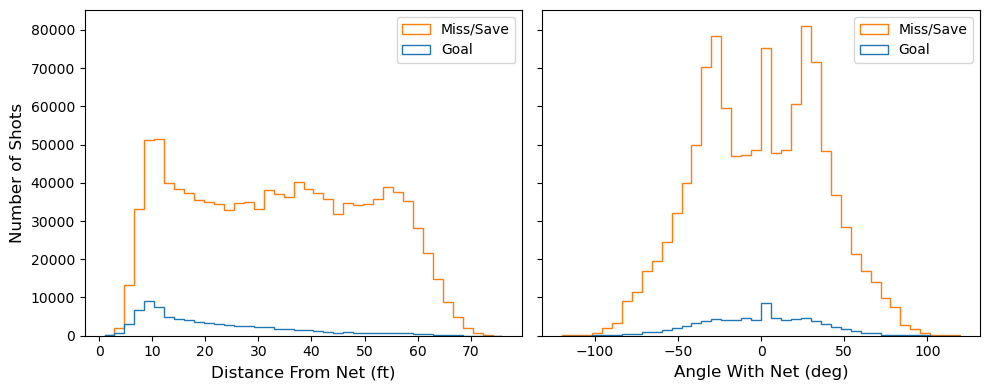

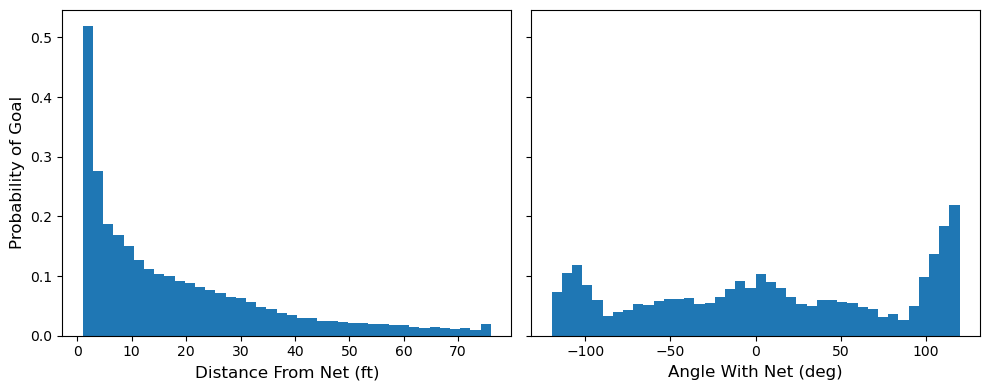

In [5]:
# Plot distributions for shot distance and angle
shot_cols = ['net_distance', 'net_angle']
x_lbls = ['Distance From Net (ft)', 'Angle With Net (deg)']

fig1, ax1 = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig2, ax2 = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, col in enumerate(shot_cols):
    # Get shot counts for goals and non-goals (misses, saves)
    shot_plt = shots_wo_blocks[['shot_result', f'{col}']]
    goal_shots = shot_plt[f'{col}'].loc[goal_mask]
    non_goal_shots = shot_plt[f'{col}'].loc[~goal_mask]
    _, bins = np.histogram(shot_plt[f'{col}'], bins=40)
    goal_cnts, _ = np.histogram(goal_shots, bins)
    non_goal_cnts, _ = np.histogram(non_goal_shots, bins)
    # print(goal_cnts)
    # print(non_goal_cnts)
    
    # Calculate the probability a shot from each distance/angle will result in a goal
    p_goal = goal_cnts / (non_goal_cnts + goal_cnts)
    width = bins[1] - bins[0]
    center = (bins[:-1] + bins[1:]) / 2

    # Plot the shot distance distribution
    # ax1[i].hist([goal_shots, non_goal_shots], bins, histtype='bar', stacked=True, label=['Goal', 'Miss/Save'])
    ax1[i].hist([goal_shots, non_goal_shots], bins, histtype='step', stacked=False, label=['Goal', 'Miss/Save'])
    ax1[i].set_xlabel(x_lbls[i], fontsize=12)
    ax1[i].legend()
    # ax1[i].set_ylim([0, 1000])
    ax2[i].bar(center, p_goal, align='center', width=width)
    ax2[i].set_xlabel(x_lbls[i], fontsize=12)
ax1[0].set_ylabel('Number of Shots', fontsize=12)
ax2[0].set_ylabel('Probability of Goal', fontsize=12)
fig1.tight_layout()
fig2.tight_layout()
# plt.show()


Total number of shots = 1214273
Total number of goals = 79331
Average shooting percentage = 6.53


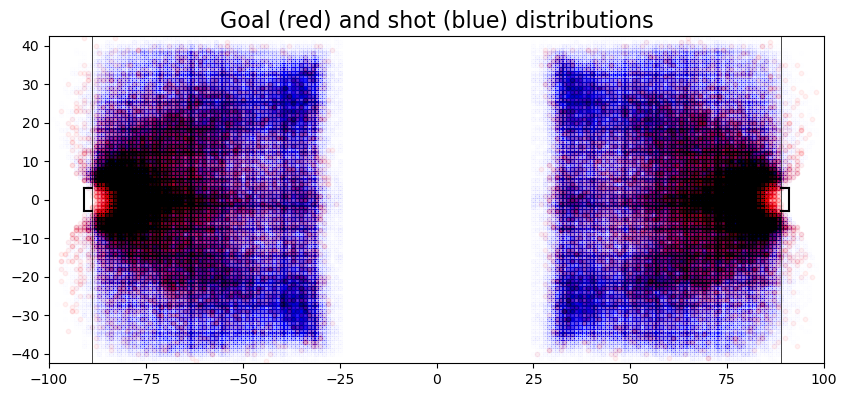

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4.25))
# Rink limits
ax.set_xlim([-100, 100])
ax.set_ylim([-42.5, 42.5])
# Goal lines
ax.plot([89, 89], [-42.5, 42.5], 'k', lw=0.5)
ax.plot([-89, -89], [-42.5, 42.5], 'k', lw=0.5)
# Nets
ax.plot([-89, -91], [-3, -3], 'k')
ax.plot([-89, -91], [3, 3], 'k')
ax.plot([-91, -91], [-3, 3], 'k')
ax.plot([89, 91], [-3, -3], 'k')
ax.plot([89, 91], [3, 3], 'k')
ax.plot([91, 91], [-3, 3], 'k')

# Masks
goals_x = shots_wo_blocks['x_coord'].loc[goal_mask]
goals_y = shots_wo_blocks['y_coord'].loc[goal_mask]
shots_x = shots_wo_blocks['x_coord'].loc[~goal_mask]
shots_y = shots_wo_blocks['y_coord'].loc[~goal_mask]
ax.scatter(goals_x, goals_y, c='r', s=10, alpha=0.05, label='Goal')
ax.scatter(shots_x, shots_y, c='b', s=10, alpha=0.002, label='Shot')
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.025), fontsize=12)
ax.set_title('Goal (red) and shot (blue) distributions', fontsize=16)

# Print statements
n_goals = len(shots_wo_blocks.loc[goal_mask])
n_shots = len(shots_wo_blocks)
print(f'Total number of shots = {n_shots}')
print(f'Total number of goals = {n_goals}')
print(f'Average shooting percentage = {100 * n_goals / n_shots:4.2f}')
# print(min(shots_df.x_coord + 100))
# print(max(shots_df.x_coord) + 100)
# print(int(min(shots_df.y_coord + 42.5)))
# print(int(max(shots_df.y_coord) + 42.5))


In [7]:
# Convert shots to list
shot_list = shots_df.to_dict('records')
# shot_list = shots_df.loc[~goal_mask].to_dict('records')
# goal_list = shots_df.loc[goal_mask].to_dict('records')


In [8]:
# Heat maps of shots and goals
res = 1
goal_map = np.ones((85 // res, 200 // res))
shot_map = np.ones_like(goal_map)
block_map = np.ones_like(goal_map)
# goal_map = np.ones((17, 40))
# shot_map = np.ones((17, 40))
for shot in shot_list:
    # x = int(shot['x_coord'] + 100)
    # y = int(shot['y_coord'] + 42.5)
    x = int(shot['x_coord'] + 100) // res
    y = int(shot['y_coord'] + 42.5) // res
    if shot['shot_result'] == 'GOAL':
        goal_map[y, x] += 1
        shot_map[y, x] += 1
    elif shot['shot_result'] == 'SHOT':
        shot_map[y, x] += 1
    elif shot['shot_result'] == 'BLOCK':
        block_map[y, x] += 1


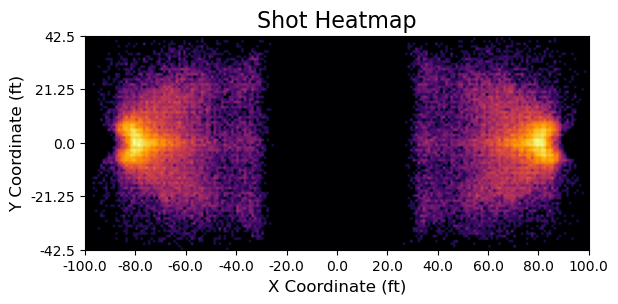

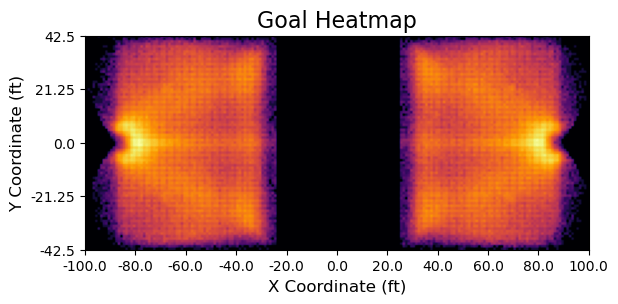

In [9]:
# Plot heatmaps of the shot and goal distributions
x_ticks_lbls = np.linspace(-100, 100, 11)
x_ticks = np.arange(0, goal_map.shape[1] + 1, goal_map.shape[1] / 10) - 0.5
y_ticks_lbls = np.linspace(-42.5, 42.5, 5)
y_ticks = np.arange(0, goal_map.shape[0] + 1, goal_map.shape[0] / 4) - 0.5

fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
# print(np.sum(shot_map) + np.sum(goal_map))
# print((np.argwhere(shot_map == 0).shape))
# print(85 * 200)
# ax.imshow(goal_map - np.mean(goal_map), cmap='bwr')
ax.imshow(np.log(goal_map), cmap='inferno', aspect='equal', origin='lower')
ax.set_xlabel('X Coordinate (ft)', fontsize=12)
ax.set_ylabel('Y Coordinate (ft)', fontsize=12)
ax.set_title('Shot Heatmap', fontsize=16)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_lbls)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_lbls)

fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
# ax.imshow(goal_map - np.mean(goal_map), cmap='bwr')
ax.imshow(np.log(shot_map), cmap='inferno', aspect='equal', origin='lower')
ax.set_xlabel('X Coordinate (ft)', fontsize=12)
ax.set_ylabel('Y Coordinate (ft)', fontsize=12)
ax.set_title('Goal Heatmap', fontsize=16)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_lbls)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_lbls);


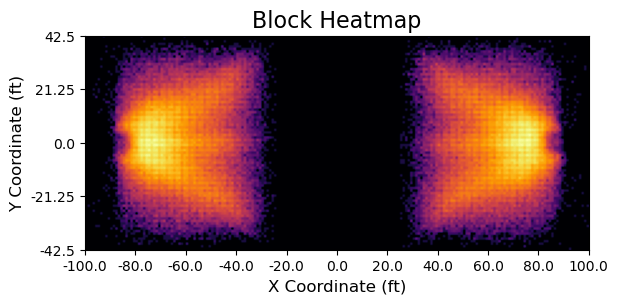

In [81]:
# Plot heatmap of blocks
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3))
# ax.imshow(block_map - np.mean(block_map), cmap='bwr')
ax.imshow(np.log(block_map), cmap='inferno', aspect='equal', origin='lower')
# ax.imshow(block_map, cmap='inferno', aspect='equal', origin='lower')
ax.set_xlabel('X Coordinate (ft)', fontsize=12)
ax.set_ylabel('Y Coordinate (ft)', fontsize=12)
ax.set_title('Block Heatmap', fontsize=16)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_lbls)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks_lbls);


## Calculating Block Probabilities

All of the following calculations are performed by binning the data. The bin sizes are chosen in an attempt to balance maximizing the resolution with providing a suitable sample size for each bin. This choice is made visually, by looking at the smoothness of the resulting distributions. Since there is a significant amount of shot data, it should be possible to have a reasonably smooth distribution for most of the data's range, When fitting a curve to these distributions, bins with fewer data points will be weighted less heavily, for example, particularly long/short shot distances and large shot angles.

Using the blocked shot data is troublesome because the location of the block, rather than the location of the shot is recorded. However, since shots travel in straigth lines, it is relatively simple to calculate the probability of a shot being blocked at a particular angle. The number of blocked shots from that angle divided by the total number of shots from that angle, should give a relative reliable estimate of the probability of a shot block at any particular angle.

Distance is much more complicated. For example, a shot block recorded at a distance of 20' could have originated at any distance greater than 20'. This needs to be accounted for. Therefore, I made a three assumptions:
1. A shot has an equal probability of being blocked anywhere between the release point and the net
2. A shot cannot be blocked at the same distance (bin) from which it was taken
3. Each block can only correspond to a single shot

I binned the shot distances and calculated the probability of a shot from the $N^{th}$ bin ($b_N$) as follows:

$$
    P(block|d_{shot}\in b_N) = \frac{\sum^{N-1}_{n=0} \frac{\text{number of blocks in }b_n}{N - n}}{\text{number of shots in }b_N}
$$

where $N-n$ is a discount factor that ensures blocks are not counted more than once

This

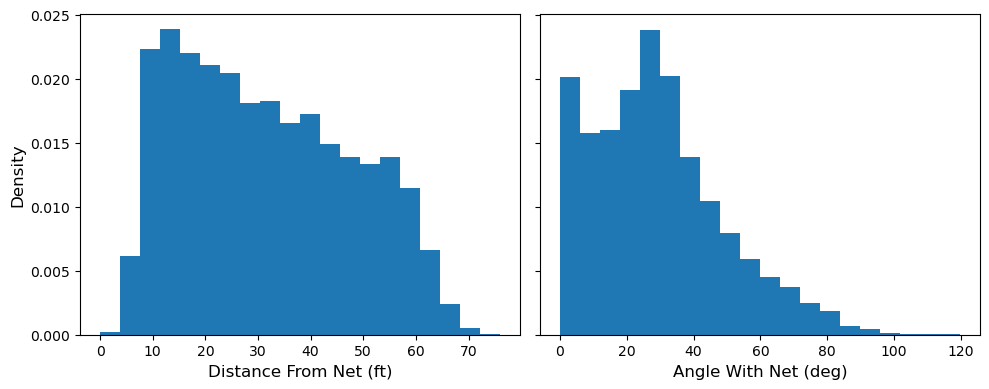

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, col in enumerate(shot_cols):
    # Get shot counts for blocks and shots through (goals, misses, saves)
    # shot_plt = shots_wo_blocks[['shot_result', f'{col}']]
    # blocked_shots = shot_plt[f'{col}'].loc[goal_mask]
    # non_goal_shots = shot_plt[f'{col}'].loc[~goal_mask]
    _, bins = np.histogram(abs(shots_df[col]), bins=40)
    block_cnts, _ = np.histogram(blocked_shots[col], bins)
    thru_cnts, _ = np.histogram(shots_wo_blocks[col], bins)
    # print(goal_cnts)
    # print(non_goal_cnts)
    
    # Calculate the probability a shot from each distance/angle will result in a goal
    p_block = block_cnts / (thru_cnts + block_cnts)
    width = bins[1] - bins[0]
    center = (bins[:-1] + bins[1:]) / 2

    # Plot the shot distance distribution
    # ax1[i].hist([goal_shots, non_goal_shots], bins, histtype='bar', stacked=True, label=['Goal', 'Miss/Save'])
    # ax1[i].hist([goal_shots, non_goal_shots], bins, histtype='step', stacked=False, label=['Goal', 'Miss/Save'])
    # ax1[i].set_xlabel(x_lbls[i], fontsize=12)
    # ax1[i].legend()
    # ax1[i].set_ylim([0, 1000])
    # axes[i].bar(center, p_block, align='center', width=width)
    axes[i].hist(abs(shots_df[col]), bins=20, density=True)
    # axes[i].hist(abs(shots_df[col]), bins=20, density=False)
    axes[i].set_xlabel(x_lbls[i], fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
# axes[0].set_ylabel('Counts', fontsize=12)
fig.tight_layout()


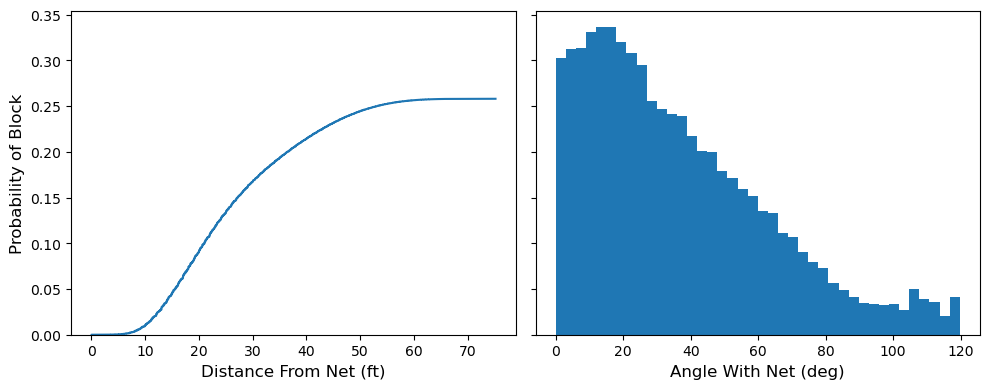

In [80]:
# Plot the probability of blocks given angle and distance
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
blocked_shots = shots_df[shots_df.shot_result == 'BLOCK']

# Calculate the probability of blocks based on angle
all_cnts_angle, bins_angle = np.histogram(abs(shots_df['net_angle']), bins=40)
# _, bins_angle = np.histogram(abs(shots_df['net_angle']), bins=40)
block_cnts_angle, _ = np.histogram(abs(blocked_shots['net_angle']), bins_angle)
# all_cnts_angle, _ = np.histogram(abs(shots_df['net_angle']), bins_angle)
# thru_cnts_angle, _ = np.histogram(abs(shots_wo_blocks['net_angle']), bins_angle)
p_block_angle = block_cnts_angle / all_cnts_angle
# p_block_angle = block_cnts_angle / (block_cnts_angle + thru_cnts_angle)
width_angle = bins_angle[1] - bins_angle[0]
center_angle = (bins_angle[:-1] + bins_angle[1:]) / 2
axes[1].bar(center_angle, p_block_angle, align='center', width=width_angle)
axes[1].set_xlabel(x_lbls[1], fontsize=12)

# Calculate the probability of blocks based on distance

# Method #1 (bin average)
# all_cnts_dist, bins_dist = np.histogram(shots_df['net_distance'], bins=40)
# block_cnts_dist, _ = np.histogram(blocked_shots['net_distance'], bins_dist)
# block_cnts_mod = block_cnts_dist / np.arange(block_cnts_dist.size)[::-1]
# print(np.arange(block_cnts_dist.size)[::-1])
# print(block_cnts_dist)
# print(block_cnts_mod)
# print(all_cnts_dist)
# # all_cnts_dist, _ = np.histogram(shots_df['net_distance'], bins_dist)
# # p_block_dist = np.zeros(block_cnts_dist.size)
# p_block_dist = block_cnts_dist / all_cnts_dist
# for N in range(1, block_cnts_dist.size):
#     # num_sum = 0
#     # for n in range(N):
#     #     if N == block_cnts_dist.size - 1:
#     #         print(block_cnts_dist[n] / (N - n))
#     #     num_sum += block_cnts_dist[n] / (N - n)
#     #     # num_sum += block_cnts_dist[n]
#     # # p_block_dist[N] = num_sum / all_cnts_dist[N]
#     p_block_dist[N] = block_cnts_mod[:N].sum() / all_cnts_dist[N]
# width_dist = bins_dist[1] - bins_dist[0]
# center_dist = (bins_dist[:-1] + bins_dist[1:]) / 2
# axes[0].bar(center_dist, p_block_dist, align='center', width=width_dist)

# Method #2 (CDF of block probability)
# https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python
p_block_avg = len(blocked_shots) / len(shots_df)
block_dists = blocked_shots['net_distance'].sort_values()
cum_density = np.linspace(0, 1, len(blocked_shots))
axes[0].plot(block_dists, cum_density * p_block_avg)
axes[0].set_xlabel(x_lbls[0], fontsize=12)
axes[0].set_ylabel('Probability of Block', fontsize=12)
fig.tight_layout();


In [ ]:
# Fits curves to the data
# https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-221#:~:text=Asymmetry%20of%20the%20lower%20and,denote%20f%20in%20the%20sequel.
# https://en.wikipedia.org/wiki/Generalised_logistic_function
# use piece-wise for angle [[0, 20], [20, 90], [90, 120]]
# Weight distance and angle contributions by number of data points within a range of the shot to be calculated for 
#  (i.e. # of points within +/-5% of the domain)

# Game State Analysis

Justification for splitting game states
- Show that goals are scored at different rates for different game states
- Show heat maps for shot distributions for different games states

Other notes:
- Scoring changes from the 2017-18 season and on (look at distributions)
    - Rates increase (goals/game)
    - Predictability using data prior to 2017-18 is worse (therefore something fundamentally changes)
